In [ ]:
import autograd.numpy as np
import capytaine as cpy
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

In [11]:
wavefreq = 0.3 # Hz
f1 = wavefreq
nfreq = 10

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

In [12]:
amplitude = 0.0625 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

In [13]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.2 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

# create mesh object for WaveBot and add internal lid
mesh_obj = load_from_meshio(mesh, 'WaveBot')
lid_mesh = mesh_obj.generate_lid(-2e-2)

fb = cpy.FloatingBody(mesh=mesh_obj, lid_mesh=lid_mesh, name="WaveBot")

In [14]:
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

In [15]:
bem_data = wot.run_bem(fb, freq)

[14:31:31] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

           WARNING  FloatingBody has no inertia_matrix field. If the FloatingBody mass is defined, it will be used 
                    for calculating the inertia matrix here. Otherwise, the neutral buoyancy assumption will be    
                    used to auto-populate.

           WARNING  FloatingBody has no hydrostatic_stiffness field. Capytaine will auto-populate the hydrostatic  
                    stiffness based on the provided mesh.

The resolution of the mesh might be insufficient for omega ranging from 15.080 to 18.850.
This warning appears when the largest panel of this mesh has radius > wavelength/8.


           WARNING  Mesh resolution for 6 problems:                                                                
                    The resolution of the mesh might be insufficient for omega ranging from 15.080 to 18.850.      
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()

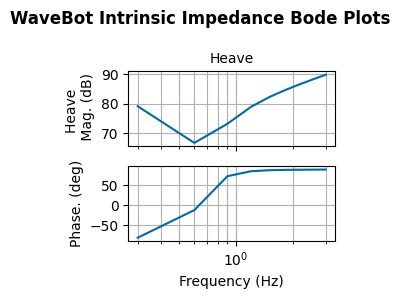

In [32]:
hd = wot.add_linear_friction(bem_data, friction=500) 
# we're not actually adding friction, but need the datavariables in hd 
hd = wot.check_radiation_damping(hd)

intrinsic_impedance = wot.hydrodynamic_impedance(hd)
fig, axes = wot.utilities.plot_bode_impedance(intrinsic_impedance,
                                              'WaveBot Intrinsic Impedance')

In [43]:
ptos = {
    'unstructured': wot.pto.PTO(ndof,
                                kinematics=np.eye(ndof),
                                controller=None,
                                impedance=None,
                                loss=None,
                                names=["PTO_Heave",]),
    'pi': wot.pto.PTO(ndof,
                      kinematics=np.eye(ndof),
                    #   controller=wot.pto.controller_pi, #TODO
                      controller=wot.pto.feedback_controller(1,True,True,False).force,
                      impedance=None,
                      loss=None,
                      names=["PTO_Heave",]),
    'p': wot.pto.PTO(ndof,
                      kinematics=np.eye(ndof),
                    #   controller=wot.pto.controller_pi, #TODO
                      controller=wot.pto.feedback_controller(1,True,False,False).force,
                      impedance=None,
                      loss=None,
                      names=["PTO_Heave",]),
}

In [47]:
# Constraint
f_max = 750.0
nsubsteps = 4

wecs = {}
obj_funs = {}
nstate_opts = {}
for key in ptos:
    
    def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
        f = ptos[key].force(wec, x_wec, x_opt, waves, nsubsteps)
        return f_max - np.abs(f.flatten())

    constraints = [{'type': 'ineq', 'fun': const_f_pto,}]
    
    wecs[key] = wot.WEC.from_bem(
        hd,
        constraints=constraints,  # TODO
        friction=None,
        f_add={'PTO': ptos[key].force_on_wec})
    obj_funs[key] = ptos[key].mechanical_average_power
    if key == 'pi':
        nstate_opts[key] = 2
    elif key == 'p':
        nstate_opts[key] = 1
    elif key == 'unstructured':
        nstate_opts[key] = 2*nfreq

[15:49:46] WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [9] to a minimum of 1e-06 N/(m/s)

           WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [9] to a minimum of 1e-06 N/(m/s)

           WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [9] to a minimum of 1e-06 N/(m/s)

In [48]:
pto_ds_list = []
wec_ds_list = []

results = {}
for key in wecs:
    print('\n-------------------------------')
    print(f'Running case: {key} controller')
    results[key] = wecs[key].solve(
        waves, 
        obj_funs[key], 
        nstate_opts[key],
        optim_options={'maxiter': 200}, 
        # x_wec_0=np.ones(wec.nfreq*2)*1e-1,
        # x_opt_0=np.ones(wec.nfreq*2)*1e-1,
        # scale_x_wec=1e1,
        # scale_x_opt=1e-3,
        # scale_obj=1e0,
        )
    
    x_wec, x_opt = wecs[key].decompose_state(results[key][0].x)
    nsubsteps = 5
    pto_f, pto_t = ptos[key].post_process(wecs[key], results[key], waves, nsubsteps=nsubsteps)
    wec_f, wec_t = wecs[key].post_process(wecs[key], results[key], waves, nsubsteps=nsubsteps)
    
    pto_ds_list.append(pto_t[0].expand_dims({'controller':[key]}))
    wec_ds_list.append(wec_t[0].expand_dims({'controller':[key]}))
    
    # opt_mechanical_average_power = results[0].fun
    # print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')
    
pto_ds = xr.merge(pto_ds_list)
wec_ds = xr.merge(wec_ds_list)

/Users/rcoe/Documents/WecOptTool/wecopttool/wecopttool/core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):



-------------------------------
Running case: unstructured controller
Optimization terminated successfully    (Exit mode 0)
            Current function value: -48.29485466761623
            Iterations: 110
            Function evaluations: 110
            Gradient evaluations: 110

-------------------------------
Running case: pi controller


/Users/rcoe/Documents/WecOptTool/wecopttool/wecopttool/core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -40.90401905775614
            Iterations: 35
            Function evaluations: 39
            Gradient evaluations: 35

-------------------------------
Running case: p controller


/Users/rcoe/Documents/WecOptTool/wecopttool/wecopttool/core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -28.32918300759299
            Iterations: 21
            Function evaluations: 23
            Gradient evaluations: 21


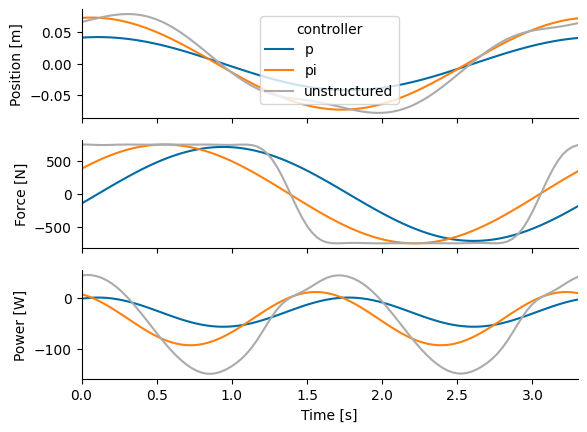

In [49]:
fig, ax = plt.subplots(nrows=3, sharex=True)
wec_ds['pos'].plot(ax=ax[0],
                   hue='controller',
                   add_legend=True)
ax[0].set_ylabel('Position [m]')

pto_ds['force'].plot(ax=ax[1],
                     hue='controller',
                     add_legend=False)
ax[1].set_ylabel('Force [N]')

pto_ds['power'].sel(type='mech').squeeze().plot(ax=ax[2],
                                                hue='controller',
                                                add_legend=False)

for axi in ax:
    axi.set_title('')
    axi.label_outer()
    axi.spines[['right', 'top']].set_visible(False)
    axi.autoscale(enable=True, axis='x', tight=True)

In [50]:
pto_ds.squeeze().power.sel(type='mech').mean(dim='time')

<xarray.DataArray 'power' (controller: 3)> Size: 24B
array([-28.32918301, -40.90401906, -48.29485467])
Coordinates:
    dof         <U9 36B 'PTO_Heave'
    type        <U4 16B 'mech'
  * controller  (controller) object 24B 'p' 'pi' 'unstructured'